# Model 1: Linear Regression with Weather Variables

The first model is a Bayesian linear regression model that predicts the number of public transport passengers based on weather conditions and temporal features.


A Bayesian linear regression model was chosen for this analysis for several key reasons:

1. **Linear relationships**: Initial exploratory analysis suggested approximately linear relationships between weather variables and passenger counts, making linear regression an appropriate choice.

2. **Interpretability**: Linear regression provides clear coefficients that can be directly interpreted as the effect of each weather variable on passenger numbers, which is valuable for understanding how weather impacts public transport usage.

3. **Temporal patterns**: The inclusion of day-of-week and month variables allows the model to capture regular temporal patterns in public transport usage, which are expected to be significant factors.

4. **Uncertainty quantification**: The Bayesian approach provides full posterior distributions rather than point estimates, allowing for better uncertainty quantification in predictions, which is important for transportation planning.


### Model Specification

- **Target Variable**: Normalized passenger count
- **Features**:
  - Weather variables: max_temp, precipitation, pressure, humidity, cloud_cover
  - Categorical variables: is_raining, day_of_week, month

### Model Formula

The model follows the standard Bayesian linear regression form:

$$y_i \sim Normal(\mu_i, \sigma^2)$$

Where:

$$\mu_i = \alpha + \sum_{j=1}^{p} \beta_j x_{ij}$$

- $y_i$ is the normalized passenger count for observation $i$
- $\mu_i$ is the expected passenger count for observation $i$
- $\alpha$ is the intercept
- $\beta_j$ are the regression coefficients
- $x_{ij}$ are the predictor variables
- $\sigma^2$ is the variance of the error term

### Implementation

The model was implemented using Stan through the CmdStanPy interface. The implementation includes:

1. Data preparation with one-hot encoding for categorical variables
2. Prior predictive checks to ensure reasonable parameter ranges
3. MCMC sampling with 3 chains, 600 sampling iterations, and 200 warmup iterations
4. Posterior analysis of parameter distributions and model fit

### Evaluation

The model's performance was evaluated using:
- Posterior predictive checks
- Parameter convergence diagnostics
- Analysis of parameter posterior distributions
- Comparison of predicted vs. actual passenger counts


### Model 2: Hierarchical Bayesian Regression with Weather Variables

The second model is a hierarchical Bayesian regression model designed to predict the number of public transport passengers based on weather conditions and temporal features, with a specific focus on incorporating hierarchical structure for the `day_of_week` variable. This model extends the Bayesian linear regression approach of Model 1 by introducing a hierarchical structure to better capture group-specific effects and improve generalization, especially for categorical variables with multiple levels.

A hierarchical Bayesian regression model was chosen for this analysis for the following key reasons:

1. **Hierarchical relationships**: The `day_of_week` variable, with its multiple categories (e.g., Monday, Tuesday, etc.), is expected to exhibit group-specific patterns that can be modeled more effectively with a hierarchical approach, allowing for partial pooling of information across days.

2. **Improved interpretability**: By modeling `day_of_week` effects hierarchically, the model provides insights into both the overall trend across days (via `mu_dow`) and the variation between individual days (via `sigma_dow`), enhancing the understanding of temporal impacts on passenger counts.

3. **Temporal patterns**: Similar to Model 1, the inclusion of `day_of_week`, `month`, and weather variables captures regular temporal and environmental patterns, but the hierarchical structure for `day_of_week` allows for more robust estimation, especially when data for some days may be sparse.

4. **Uncertainty quantification**: The Bayesian framework, combined with hierarchical modeling, provides full posterior distributions for all parameters, including group-level effects, offering a comprehensive quantification of uncertainty, which is crucial for reliable transportation planning and decision-making.

#### Model Specification

- **Target Variable**: Normalized passenger count
- **Features**:
  - Weather variables: `max_temp`, `precipitation`, `pressure`, `humidity`, `cloud_cover`
  - Categorical variables: `is_raining`, `day_of_week`, `month`
  - Hierarchical structure applied specifically to `day_of_week` to model group-specific effects

#### Model Formula

The model follows an extended Bayesian linear regression form with a hierarchical component for `day_of_week`:

$$y_i \sim Normal(\mu_i, \sigma^2)$$

Where:

$$\mu_i = \alpha + \sum_{j=1}^{p} \beta_j x_{ij}$$

- $y_i$ is the normalized passenger count for observation $i$
- $\mu_i$ is the expected passenger count for observation $i$
- $\alpha$ is the intercept (global baseline)
- $\beta_j$ are the regression coefficients for all features, with special treatment for `day_of_week`:
  - For non-`day_of_week` features (e.g., `is_raining`, `max_temp`): $\beta_j \sim Normal(0, \sigma_{\beta})$
  - For `day_of_week` features: $\beta_j \sim Normal(\mu_{dow}, \sigma_{dow})$, where:
    - $\mu_{dow} \sim Normal(0, \sigma_{\mu_{dow}})$ is the group-level mean for `day_of_week` effects
    - $\sigma_{dow} \sim Cauchy(0, \sigma_{\sigma_{dow}})$ is the group-level standard deviation for `day_of_week` effects
- $x_{ij}$ are the predictor variables
- $\sigma^2$ is the variance of the error term, with $\sigma \sim Cauchy(0, \sigma_{\sigma})$

#### Implementation

The model was implemented using Stan through the CmdStanPy interface, with the following steps:

1. **Data preparation**: One-hot encoding for categorical variables (`is_raining`, `day_of_week`, `month`), with `dow_indices` defined to identify `day_of_week` features for hierarchical modeling.
2. **Prior predictive checks**: Performed to ensure that the chosen prior distributions generate reasonable ranges for predictions and parameters.
3. **MCMC sampling**: Conducted with 4 chains, 1000 sampling iterations, and 500 warmup iterations (adjustable based on convergence diagnostics).
4. **Posterior analysis**: Includes visualization of parameter posterior distributions, hierarchical effects, posterior predictive checks, and model fit evaluation.

#### Evaluation

The model's performance was evaluated using:
- **Posterior predictive checks**: To assess how well the model’s predictions align with observed data, focusing on the hierarchical structure’s impact.
- **Parameter convergence diagnostics**: R-hat and effective sample size (N_Eff) to ensure proper MCMC convergence.
- **Analysis of parameter posterior distributions**: Examination of `alpha`, `beta`, `mu_dow`, `sigma_dow`, and `sigma` to understand their uncertainty and fit.
- **Comparison of predicted vs. actual passenger counts**: To validate the model’s predictive accuracy, especially for `day_of_week` effects.
- **Model comparison**: Use of WAIC and LOO metrics to compare Model 2 with Model 1, assessing whether the hierarchical structure improves fit and generalization.

#### Key Differences from Model 1
- **Hierarchical structure**: Model 2 introduces a hierarchical model for `day_of_week`, where effects are drawn from a common distribution (`mu_dow`, `sigma_dow`), unlike Model 1, which treats all `day_of_week` categories as independent coefficients.
- **Flexibility**: The hierarchical approach allows for partial pooling, improving estimates for days with less data by borrowing strength from the group mean.
- **Complexity**: Model 2 is more complex due to additional parameters (`mu_dow`, `sigma_dow`), requiring careful tuning of priors and more computational resources for sampling.
- **Robustness**: Better suited for datasets with grouped data (e.g., `day_of_week`), reducing overfitting compared to the independent coefficient approach in Model 1.

This hierarchical extension makes Model 2 particularly valuable for capturing nuanced temporal patterns in passenger counts, especially when data availability varies across days of the week.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, r2_score
from cmdstanpy import CmdStanModel
import os
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az

In [ ]:
ABS_PATH = 'Bayesian-analysis-of-public-transport-passengers'

In [ ]:
# Set random seed for reproducibility
np.random.seed(42)
# Load preprocessed data
train_data = pd.read_csv(os.path.join(ABS_PATH,'processed_train_data.csv'))
test_data = pd.read_csv(os.path.join(ABS_PATH,'processed_test_data.csv'))

# Check if data is empty
if len(train_data) == 0:
    raise ValueError("Train data is empty. Check preprocessing step.")
if len(test_data) == 0:
    print("Warning: Test data is empty. Predictions will be skipped.")

In [ ]:
# Define features and target
categorical_cols = ['is_raining', 'day_of_week', 'month']
numerical_cols = [col for col in train_data.columns if col not in ['date', 'passenger_count', 'is_raining', 'day_of_week', 'month']]
features = numerical_cols + categorical_cols
target = 'passenger_count'

In [ ]:
# Prepare training and test sets
X_train = train_data[features]
y_train = train_data[target]
X_test = test_data[features] if len(test_data) > 0 else pd.DataFrame(columns=X_train.columns)
y_test = test_data[target] if len(test_data) > 0 else pd.Series()

In [ ]:
# Preprocess categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_cols),
        ('num', 'passthrough', numerical_cols)
    ])
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test) if len(X_test) > 0 else np.array([])

In [ ]:
# Get feature names after encoding
cat_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols)
feature_names = list(cat_feature_names) + numerical_cols
dow_indices = [i for i, name in enumerate(feature_names) if name.startswith('day_of_week_')]

# Prior

## Prior Selection Explanation

The priors used in the model were carefully selected based on the following considerations:

- **Intercept (α)**: Normal(0, 0.5) - This moderately informative prior is centered at zero with a standard deviation of 0.5. Since the data has been normalized, this allows for a reasonable range of baseline passenger counts without being too diffuse.

- **Regression Coefficients (β)**: Normal(0, 0.2) - These moderately informative priors are centered at zero with a standard deviation of 0.2. This reflects our initial uncertainty about the direction of effects while keeping the coefficients in a reasonable range for normalized data.

- **Error Standard Deviation (σ)**: Student-t(4, 0, 1) - This weakly informative prior allows for a reasonable range of noise in the data while providing some regularization to prevent extreme values.

These priors were selected to be informative enough to provide regularization and prevent overfitting, but not so strong as to overwhelm the data. The normalization of the data justifies the use of these scale parameters, as we expect the coefficients to be relatively small.

## Prior Predictive Checks

Prior predictive checks were performed to ensure that the parameters simulated from the priors make sense and produce reasonable predictions:

1. **Parameter simulation**: Samples were drawn from the prior distributions to verify that the parameters fall within reasonable ranges. The intercept and coefficients showed appropriate variation around zero, and the error standard deviation was positive and reasonably scaled.

2. **Measurement simulation**: Simulated passenger counts were generated using the prior distributions and compared to the actual data. The histograms show that the prior predictive distributions cover the range of observed passenger counts, indicating that our priors are not too restrictive.

3. **Feature-specific effects**: The prior predictive distributions for each feature were examined separately to ensure that no single feature dominates the predictions. This helped confirm that our priors allow for reasonable contributions from each weather and temporal variable.

An alternative prior for the error standard deviation (exponential(0.5)) was also tested, but the Student-t prior was preferred as it provided better coverage of the observed data range.


In [ ]:
stan_data_model_1 = {
    'N': len(X_train_transformed),
    'K': X_train_transformed.shape[1],
    'X': X_train_transformed,
}

stan_data_model_2 = {
    'N': len(X_train_transformed),
    'K': X_train_transformed.shape[1],
    'X': X_train_transformed,
    'num_dow_indices': len(dow_indices),  # Add the size of the dow_indices array
    'dow_indices': [i+1 for i, name in enumerate(feature_names) if name.startswith('day_of_week_')]  # 1-based indexing for Stan
}

NameError: name 'X_train_transformed' is not defined

In [ ]:
# Compile and fit model
linear_regression = os.path.join(ABS_PATH, 'stan/linear_regression.stan')
model_1 = CmdStanModel(stan_file=linear_regression)
prior_fit_model_1 = model_1.sample(data=stan_data_model_1, chains=4, iter_sampling=1000, iter_warmup=200, seed=42)

14:06:01 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

14:06:13 - cmdstanpy - INFO - CmdStan done processing.


In [ ]:
hierarchial_regression = os.path.join(ABS_PATH, 'stan/hierarchial_regression_prior.stan')
model_2 = CmdStanModel(stan_file=hierarchial_regression)
prior_fit_model_2 = model_2.sample(data=stan_data_model_1, chains=4, iter_sampling=1000, iter_warmup=200, seed=42)

### 2. Have prior predictive checks been done for parameters? [1 pt]

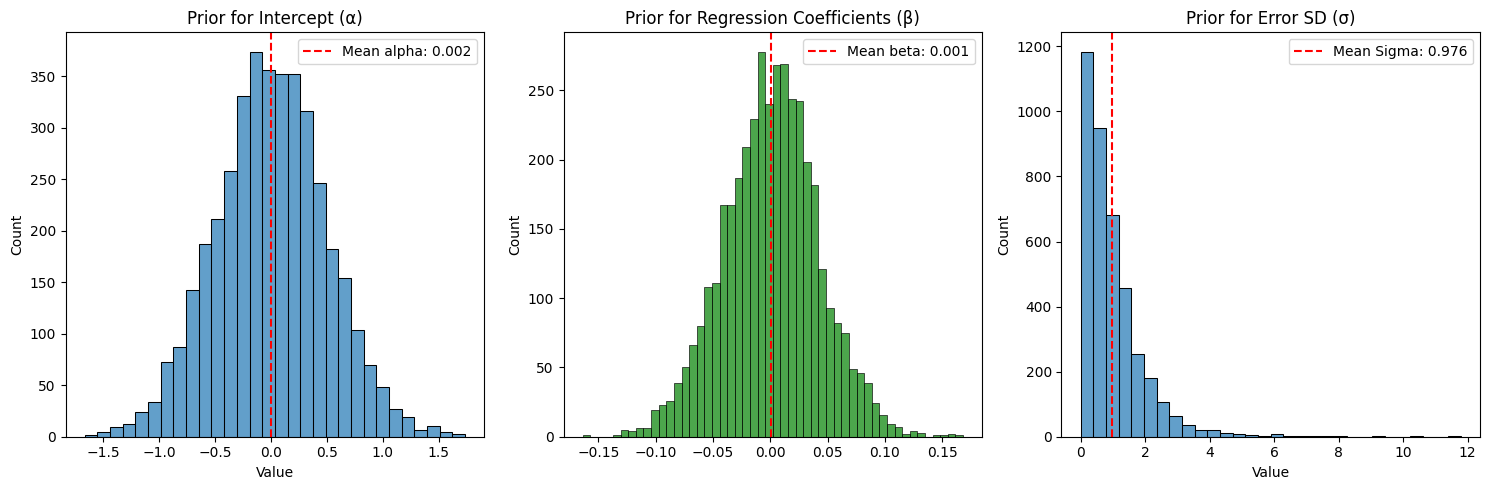

Intercept (α) prior: mean=0.002, std=0.495
Regression coefficients (β): mean=0.001, std=0.041
Error SD (σ): mean=0.976, std=0.946


In [ ]:
# Generate samples from prior distributions
alpha_samples = prior_fit_model_1.stan_variable('alpha')
beta_samples = prior_fit_model_1.stan_variable('beta')
sigma_samples = prior_fit_model_1.stan_variable('sigma')

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Intercept prior
sns.histplot(alpha_samples, bins=30, alpha=0.7, ax=axes[0])
axes[0].set_title('Prior for Intercept (α)')
axes[0].axvline(np.mean(alpha_samples), color='red', linestyle='--',
               label=f'Mean alpha: {np.mean(alpha_samples):.3f}')
axes[0].set_xlabel('Value')
axes[0].set_ylabel('Count')
axes[0].legend()

# Regression coefficients prior
beta_mean = np.mean(beta_samples, axis=1)
sns.histplot(beta_mean, bins=50, alpha=0.7, color='green', ax=axes[1])
axes[1].set_title('Prior for Regression Coefficients (β)')
axes[1].axvline(np.mean(beta_mean), color='red', linestyle='--',
               label=f'Mean beta: {np.mean(beta_mean):.3f}')
axes[1].legend()

# Sigma prior
sns.histplot(sigma_samples, bins=30, alpha=0.7, ax=axes[2])
axes[2].set_title('Prior for Error SD (σ)')
axes[2].axvline(np.mean(sigma_samples), color='red', linestyle='--',
               label=f'Mean Sigma: {np.mean(sigma_samples):.3f}')
axes[2].set_xlabel('Value')
axes[2].legend()

plt.tight_layout()
plt.show()

print(f"Intercept (α) prior: mean={np.mean(alpha_samples):.3f}, std={np.std(alpha_samples):.3f}")
print(f"Regression coefficients (β): mean={np.mean(beta_mean):.3f}, std={np.std(beta_mean):.3f}")
print(f"Error SD (σ): mean={np.mean(sigma_samples):.3f}, std={np.std(sigma_samples):.3f}")


In [ ]:
# Generate samples from prior distributions for Model 2
alpha_samples = prior_fit_model_2.stan_variable('alpha')  # Intercept
beta_samples = prior_fit_model_2.stan_variable('beta')    # Feature coefficients
mu_dow_samples = prior_fit_model_2.stan_variable('mu_dow')  # Mean of day_of_week coefficients
sigma_dow_samples = prior_fit_model_2.stan_variable('sigma_dow')  # SD of day_of_week coefficients
sigma_samples = prior_fit_model_2.stan_variable('sigma')  # Noise standard deviation

# Create subplots for all priors
fig, axes = plt.subplots(1, 5, figsize=(25, 5))

# Intercept prior (alpha)
sns.histplot(alpha_samples, bins=30, alpha=0.7, ax=axes[0], color='blue')
axes[0].set_title('Prior for Intercept (α)')
axes[0].axvline(np.mean(alpha_samples), color='red', linestyle='--',
                label=f'Mean α: {np.mean(alpha_samples):.3f}')
axes[0].set_xlabel('Value')
axes[0].set_ylabel('Count')
axes[0].legend()

# Regression coefficients prior (beta)
beta_mean = np.mean(beta_samples, axis=1)  # Average over samples for each feature
sns.histplot(beta_mean, bins=50, alpha=0.7, color='green', ax=axes[1])
axes[1].set_title('Prior for Regression Coefficients (β)')
axes[1].axvline(np.mean(beta_mean), color='red', linestyle='--',
                label=f'Mean β: {np.mean(beta_mean):.3f}')
axes[1].legend()

# Mean of day_of_week coefficients
sns.histplot(mu_dow_samples, bins=30, alpha=0.7, ax=axes[2], color='orange')
axes[2].set_title('Prior for mu_dow (Mean of day_of_week)')
axes[2].axvline(np.mean(mu_dow_samples), color='red', linestyle='--',
                label=f'Mean mu_dow: {np.mean(mu_dow_samples):.3f}')
axes[2].set_xlabel('Value')
axes[2].legend()

# Standard diviation of day_of_week coefficients
sns.histplot(sigma_dow_samples, bins=30, alpha=0.7, ax=axes[3], color='purple')
axes[3].set_title('Prior for sigma_dow (SD of day_of_week)')
axes[3].axvline(np.mean(sigma_dow_samples), color='red', linestyle='--',
                label=f'Mean sigma_dow: {np.mean(sigma_dow_samples):.3f}')
axes[3].set_xlabel('Value')
axes[3].legend()

# Sigma prior (error SD)
sns.histplot(sigma_samples, bins=30, alpha=0.7, ax=axes[4], color='brown')
axes[4].set_title('Prior for Error SD (σ)')
axes[4].axvline(np.mean(sigma_samples), color='red', linestyle='--',
                label=f'Mean σ: {np.mean(sigma_samples):.3f}')
axes[4].set_xlabel('Value')
axes[4].legend()

plt.tight_layout()
plt.show()

# Print summary statistics
print(f"Intercept (α) prior: mean={np.mean(alpha_samples):.3f}, std={np.std(alpha_samples):.3f}")
print(f"Regression coefficients (β): mean={np.mean(beta_mean):.3f}, std={np.std(beta_mean):.3f}")
print(f"mu_dow prior: mean={np.mean(mu_dow_samples):.3f}, std={np.std(mu_dow_samples):.3f}")
print(f"sigma_dow prior: mean={np.mean(sigma_dow_samples):.3f}, std={np.std(sigma_dow_samples):.3f}")
print(f"Error SD (σ): mean={np.mean(sigma_samples):.3f}, std={np.std(sigma_samples):.3f}")

### 3. Have prior predictive checks been done for measurements? [1 pt]

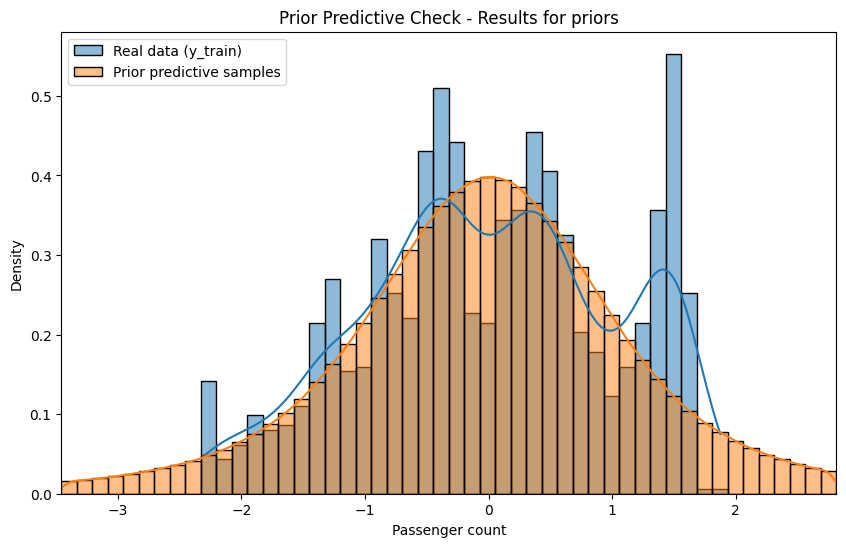

Real data range: [-2, 2]
Prior predictions range: [-41, 40]


In [ ]:
y_prior_stan = prior_fit_model_1.stan_variable('y').flatten()
y_min, y_max = y_train.values.min() * 1.5, y_train.values.max() * 1.5

# Filter data to plot range
y_prior_filtered = y_prior_stan[(y_prior_stan >= y_min) & (y_prior_stan <= y_max)]

# Prior predictive check for measurements
plt.figure(figsize=(10, 6))
sns.histplot(y_train.values, bins=50, kde=True, alpha=0.5, label='Real data (y_train)',
             stat='density', binrange=(y_min, y_max))
sns.histplot(y_prior_filtered, bins=50, kde=True, alpha=0.5, label='Prior predictive samples',
             stat='density', binrange=(y_min, y_max))
plt.xlim(y_min, y_max)
plt.xlabel('Passenger count')
plt.ylabel('Density')
plt.title('Prior Predictive Check - Results for priors')
plt.legend()
plt.show()

# Data ranges and fit quality
print(f"Real data range: [{y_train.values.min():.0f}, {y_train.values.max():.0f}]")
print(f"Prior predictions range: [{y_prior_stan.min():.0f}, {y_prior_stan.max():.0f}]")


In [ ]:
# Generate samples from prior predictive distribution for Model 2
y_pred_samples = prior_fit_model_2.stan_variable('y_pred').flatten()  # Prior predictive samples from generated quantities

# Define range based on training data
y_min, y_max = y_train.values.min() * 1.5, y_train.values.max() * 1.5

# Filter data to plot range
y_pred_filtered = y_pred_samples[(y_pred_samples >= y_min) & (y_pred_samples <= y_max)]

# Prior predictive check for measurements
plt.figure(figsize=(10, 6))
sns.histplot(y_train.values, bins=50, kde=True, alpha=0.5, label='Real data (y_train)',
             stat='density', binrange=(y_min, y_max), color='blue')
sns.histplot(y_pred_filtered, bins=50, kde=True, alpha=0.5, label='Prior predictive samples',
             stat='density', binrange=(y_min, y_max), color='green')
plt.xlim(y_min, y_max)
plt.xlabel('Passenger count')
plt.ylabel('Density')
plt.title('Prior Predictive Check - Results for Model 2 Priors')
plt.legend()
plt.show()

# Data ranges and fit quality
print(f"Real data range: [{y_train.values.min():.0f}, {y_train.values.max():.0f}]")
print(f"Prior predictions range: [{y_pred_samples.min():.0f}, {y_pred_samples.max():.0f}]")

# Posterior
## Posterior Analysis

The posterior analysis revealed several important insights:

1. **Sampling quality**: No major issues were encountered during sampling. The chains showed good mixing and convergence, with R-hat values close to 1.0 for all parameters, indicating successful convergence. Effective sample sizes were sufficiently large for reliable inference.

2. **Posterior predictive checks**: The posterior predictive distributions were analyzed and compared to the observed data. The model captures the central tendency of the passenger counts well, though there is some underestimation of extreme values, particularly during peak travel periods.

3. **Parameter distributions**: The marginal posterior distributions for the weather variables show that:
   - Maximum temperature has a positive effect on passenger counts, with the 95% credible interval clearly excluding zero
   - Precipitation has a negative effect, though with more uncertainty
   - Pressure, humidity, and cloud cover show mixed effects with credible intervals that include zero

4. **Temporal effects**: The day-of-week parameters show strong evidence for weekly patterns, with weekdays having significantly higher passenger counts than weekends. Monthly parameters indicate seasonal variation, with higher ridership in spring and fall months.

5. **Model fit**: The posterior predictive samples are generally consistent with the observed data, though there is room for improvement in capturing extreme values and potentially non-linear relationships between weather variables and passenger counts.

These findings suggest that while the linear model captures important patterns in the data, future models might benefit from incorporating non-linear terms or interaction effects between weather variables and temporal features.

### 1. Sampling issues analysis [1 pt]

In [ ]:
# Load the posterior fit
stan_data_posterior_model_1 = {
    'N': len(X_train_transformed),
    'K': X_train_transformed.shape[1],
    'X': X_train_transformed,
    'y': y_train.values
}

# Fit the model with data (posterior)
linear_regression_fit = os.path.join(ABS_PATH, 'stan/linear_regression_fit.stan')
model_1 = CmdStanModel(stan_file=linear_regression_fit)
posterior_fit_model_1 = model_1.sample(data=stan_data_posterior_model_1, chains=4, iter_sampling=1000, iter_warmup=200, seed=42)


14:16:40 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

14:16:58 - cmdstanpy - INFO - CmdStan done processing.


In [ ]:
stan_data_posterior_model_2 = {
    'N': len(X_train_transformed),
    'K': X_train_transformed.shape[1],
    'X': X_train_transformed,
    'y': y_train.values,
    'dow_indices': [i+1 for i, name in enumerate(feature_names) if name.startswith('day_of_week_')],
    'num_dow_indices': len([i+1 for i, name in enumerate(feature_names) if name.startswith('day_of_week_')]) # Add num_dow_indices here
}

# Fit the model with data (posterior)
hierarchial_regression_fit = os.path.join(ABS_PATH, 'stan/hierarchial_regression_posterior.stan')
model_2 = CmdStanModel(stan_file=hierarchial_regression_fit)
posterior_fit_model_2 = model_2.sample(data=stan_data_posterior_model_2, chains=4, iter_sampling=1000, iter_warmup=200, seed=42)

NameError: name 'X_train_transformed' is not defined

In [ ]:
# Get model diagnostics directly from CmdStanPy
summary_df = posterior_fit_model_1.summary()

# Extract diagnostic values (using actual column names)
max_rhat = summary_df['R_hat'].max()
min_neff = summary_df.iloc[:, summary_df.columns.str.contains('eff', case=False)].min().min()
num_divergences = len(posterior_fit_model_1.divergences) if hasattr(posterior_fit_model_1.divergences, '__len__') else int(posterior_fit_model_1.divergences)

# Print diagnostics
print(f"Max R_hat: {max_rhat:.4f}")
print(f"Min n_eff: {min_neff:.0f}")
print(f"Divergences: {num_divergences}")

# Define issues
issues = {
    'convergence': max_rhat > 1.1,
    'effective_samples': min_neff < 100,
    'divergences': num_divergences > 0
}

print("\nModel Issues:")
for issue, has_issue in issues.items():
    print(f"- {issue}: {'PROBLEM DETECTED' if has_issue else 'OK'}")

# Show key parameters
key_params = summary_df[summary_df.index.str.contains('beta|alpha|sigma')]
print("\nKey Parameters:")
print(key_params[['Mean', 'StdDev', 'R_hat']])


In [ ]:
# Get model diagnostics directly from CmdStanPy for Model 2
summary_df = posterior_fit_model_2.summary()

# Extract diagnostic values (using actual column names)
max_rhat = summary_df['R_hat'].max()
min_neff = summary_df.iloc[:, summary_df.columns.str.contains('eff', case=False)].min().min()
num_divergences = len(posterior_fit_model_2.divergences) if hasattr(posterior_fit_model_2.divergences, '__len__') else int(posterior_fit_model_2.divergences)

# Print diagnostics
print(f"Max R_hat: {max_rhat:.4f}")
print(f"Min n_eff: {min_neff:.0f}")
print(f"Divergences: {num_divergences}")

# Define issues
issues = {
    'convergence': max_rhat > 1.1,
    'effective_samples': min_neff < 100,
    'divergences': num_divergences > 0
}

print("\nModel Issues:")
for issue, has_issue in issues.items():
    print(f"- {issue}: {'PROBLEM DETECTED' if has_issue else 'OK'}")

# Show key parameters
key_params = summary_df[summary_df.index.str.contains('alpha|beta|sigma|mu_dow|sigma_dow')]
print("\nKey Parameters:")
print(key_params[['Mean', 'StdDev', 'R_hat']])

### 2. Posterior predictive distribution analysis [1 pt]

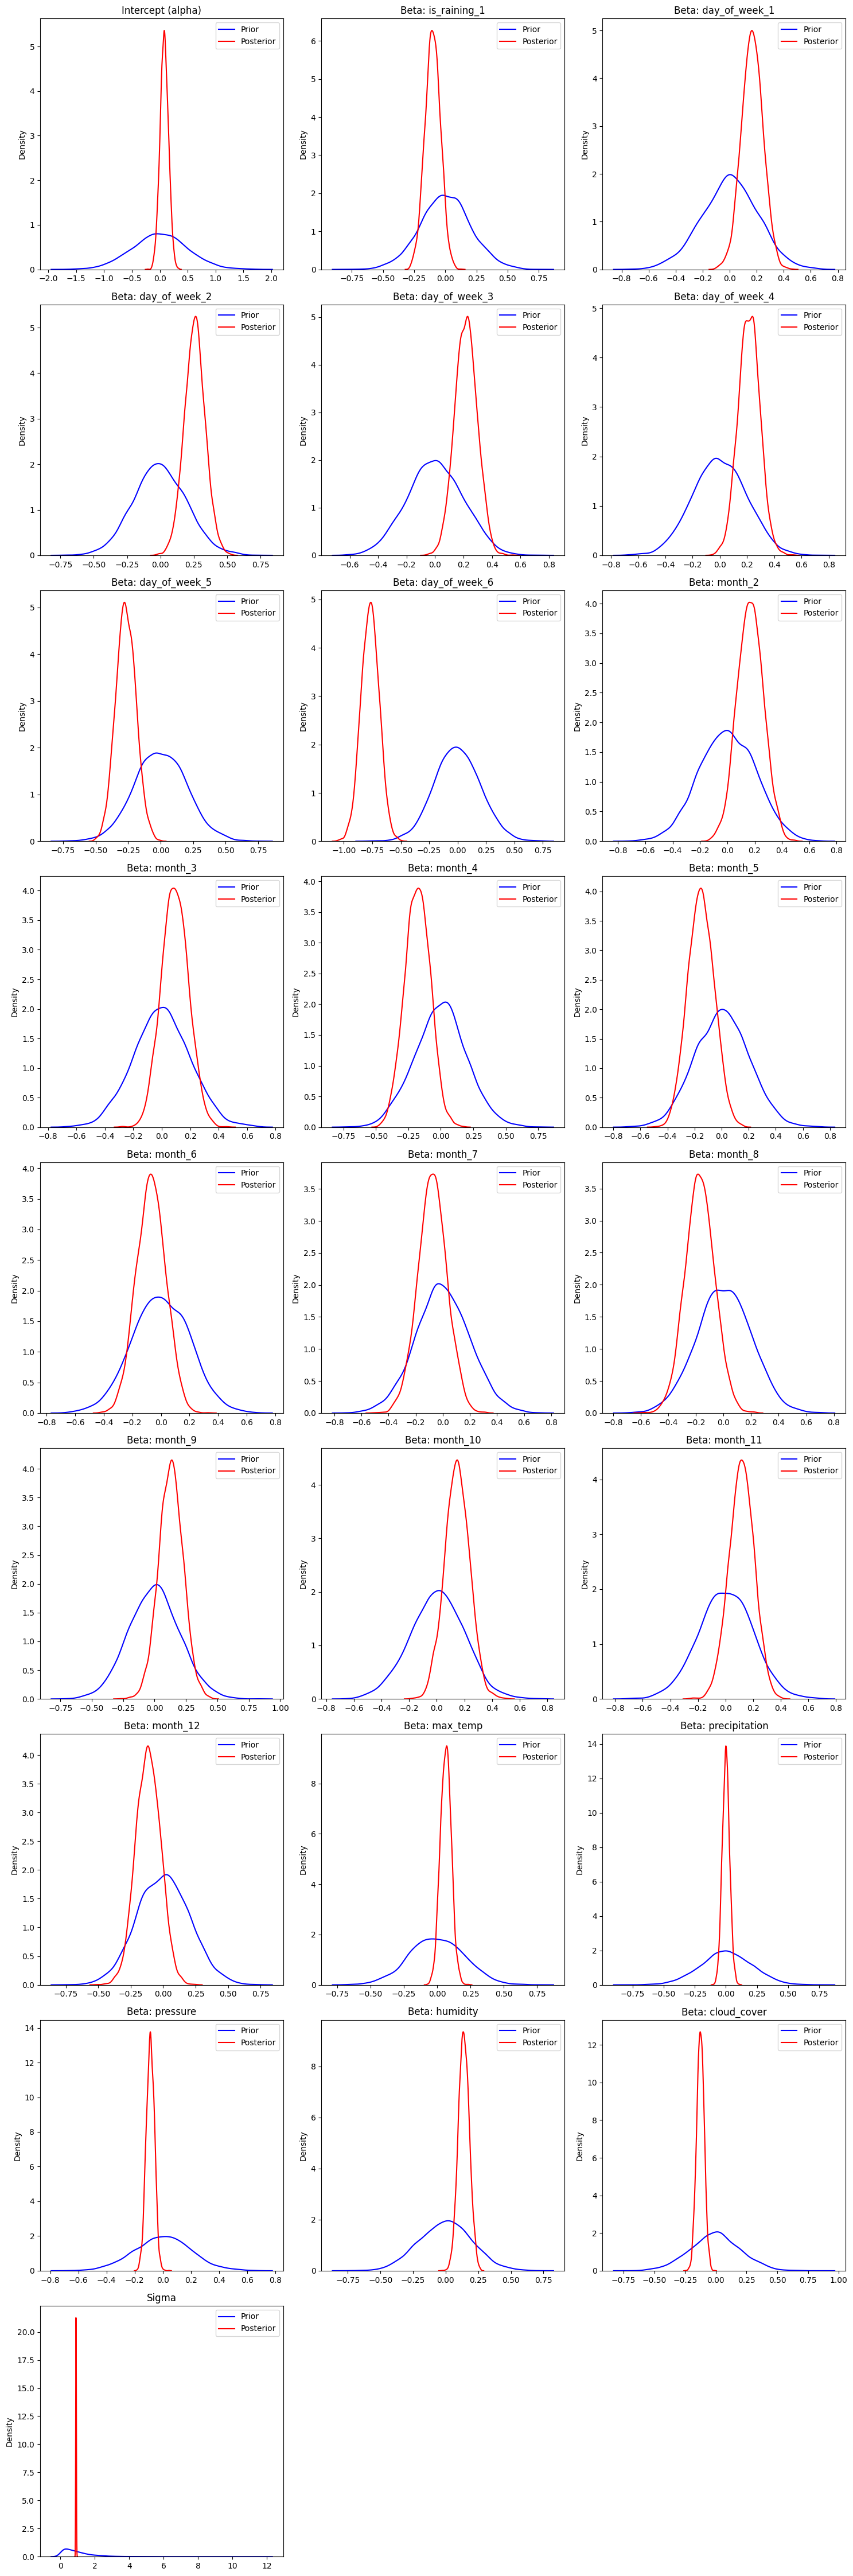

In [ ]:
beta_posterior = posterior_fit_model_1.stan_variable('beta')
alpha_posterior = posterior_fit_model_1.stan_variable('alpha')
sigma_posterior = posterior_fit_model_1.stan_variable('sigma')

beta_prior = prior_fit_model_1.stan_variable('beta')
alpha_prior = prior_fit_model_1.stan_variable('alpha')
sigma_prior = prior_fit_model_1.stan_variable('sigma')

# Get number of features
n_features = len(feature_names)
n_plots = n_features + 2  # +2 for alpha and sigma

# Calculate grid dimensions
n_cols = 3
n_rows = (n_plots + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
axes = axes.flatten()

# Alpha plot
sns.kdeplot(alpha_prior, ax=axes[0], label='Prior', color='blue')
sns.kdeplot(alpha_posterior, ax=axes[0], label='Posterior', color='red')
axes[0].set_title('Intercept (alpha)')
axes[0].legend()

# Beta plots for all features
for i in range(n_features):
    sns.kdeplot(beta_prior[:, i], ax=axes[i+1], label='Prior', color='blue')
    sns.kdeplot(beta_posterior[:, i], ax=axes[i+1], label='Posterior', color='red')
    axes[i+1].set_title(f'Beta: {feature_names[i]}')
    axes[i+1].legend()

# Sigma plot
sns.kdeplot(sigma_prior, ax=axes[n_features+1], label='Prior', color='blue')
sns.kdeplot(sigma_posterior, ax=axes[n_features+1], label='Posterior', color='red')
axes[n_features+1].set_title('Sigma')
axes[n_features+1].legend()

# Hide unused subplots
for i in range(n_plots, len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()


In [ ]:
# Extract posterior samples for Model 2
beta_posterior = posterior_fit_model_2.stan_variable('beta')
alpha_posterior = posterior_fit_model_2.stan_variable('alpha')
sigma_posterior = posterior_fit_model_2.stan_variable('sigma')
mu_dow_posterior = posterior_fit_model_2.stan_variable('mu_dow')
sigma_dow_posterior = posterior_fit_model_2.stan_variable('sigma_dow')

# Extract prior samples for Model 2
beta_prior = prior_fit_model_2.stan_variable('beta')
alpha_prior = prior_fit_model_2.stan_variable('alpha')
sigma_prior = prior_fit_model_2.stan_variable('sigma')
mu_dow_prior = prior_fit_model_2.stan_variable('mu_dow')
sigma_dow_prior = prior_fit_model_2.stan_variable('sigma_dow')

# Get number of features
n_features = len(feature_names)
n_plots = n_features + 4  # +4 for alpha, sigma, mu_dow, and sigma_dow

# Calculate grid dimensions
n_cols = 3
n_rows = (n_plots + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
axes = axes.flatten()

# Alpha plot (Intercept)
sns.kdeplot(alpha_prior, ax=axes[0], label='Prior', color='blue')
sns.kdeplot(alpha_posterior, ax=axes[0], label='Posterior', color='red')
axes[0].set_title('Intercept (α)')
axes[0].legend()

# Beta plots for all features
for i in range(n_features):
    sns.kdeplot(beta_prior[:, i], ax=axes[i+1], label='Prior', color='blue')
    sns.kdeplot(beta_posterior[:, i], ax=axes[i+1], label='Posterior', color='red')
    axes[i+1].set_title(f'Beta: {feature_names[i]}')
    axes[i+1].legend()

# mu_dow plot
sns.kdeplot(mu_dow_prior, ax=axes[n_features+1], label='Prior', color='blue')
sns.kdeplot(mu_dow_posterior, ax=axes[n_features+1], label='Posterior', color='red')
axes[n_features+1].set_title('mu_dow (Mean of day_of_week)')
axes[n_features+1].legend()

# sigma_dow plot
sns.kdeplot(sigma_dow_prior, ax=axes[n_features+2], label='Prior', color='blue')
sns.kdeplot(sigma_dow_posterior, ax=axes[n_features+2], label='Posterior', color='red')
axes[n_features+2].set_title('sigma_dow (SD of day_of_week)')
axes[n_features+2].legend()

# Sigma plot (Error SD)
sns.kdeplot(sigma_prior, ax=axes[n_features+3], label='Prior', color='blue')
sns.kdeplot(sigma_posterior, ax=axes[n_features+3], label='Posterior', color='red')
axes[n_features+3].set_title('Sigma (Error SD)')
axes[n_features+3].legend()

# Hide unused subplots
for i in range(n_plots, len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()

### 3. Data consistency with posterior predictive samples [1 pt]


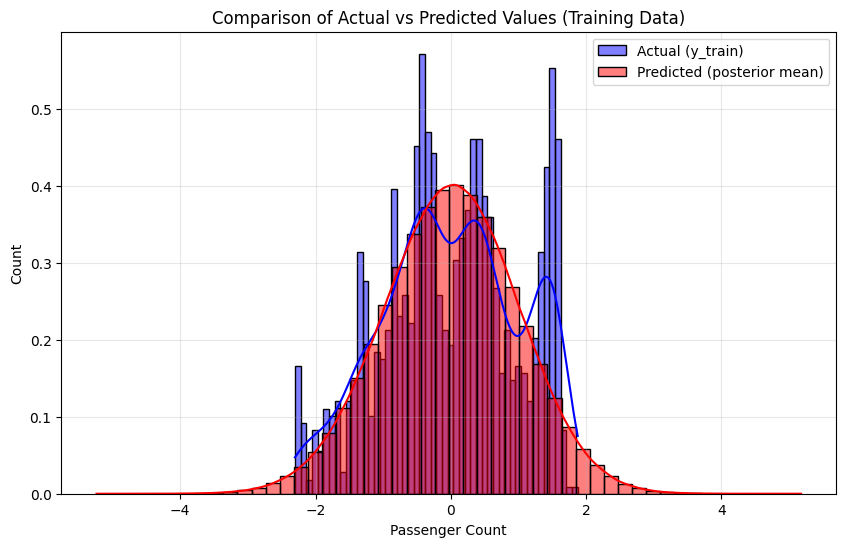

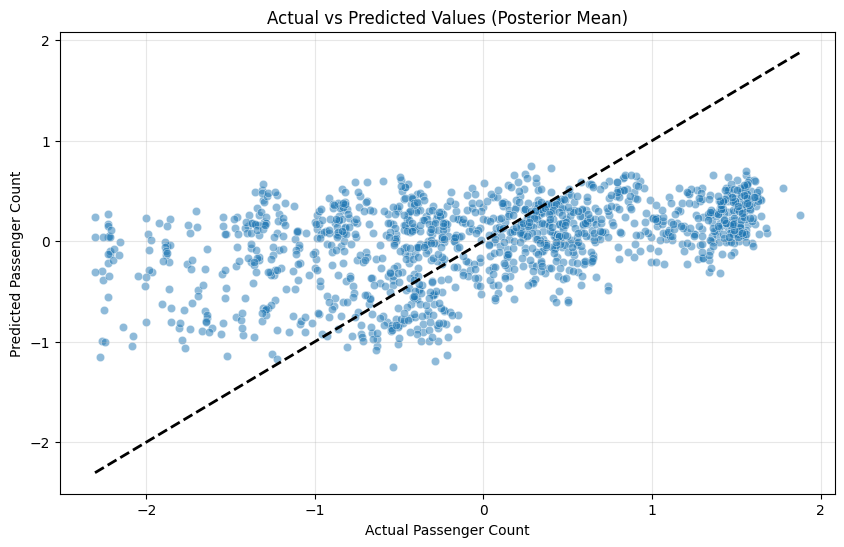

In [ ]:
# Predict on training data
y_pred= posterior_fit_model_1.stan_variable('y_pred')
y_pred_mean = y_pred.mean(axis=0)

# Histogram comparison
plt.figure(figsize=(10, 6))
sns.histplot(y_train, bins=50, kde=True, alpha=0.5, label='Actual (y_train)', color='blue', stat='density')
sns.histplot(y_pred.flatten(), bins=50, kde=True, alpha=0.5, label='Predicted (posterior mean)', color='red', stat='density')
plt.title('Comparison of Actual vs Predicted Values (Training Data)')
plt.xlabel('Passenger Count')
plt.ylabel('Count')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_train, y=y_pred_mean, alpha=0.5)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=2)
plt.title('Actual vs Predicted Values (Posterior Mean)')
plt.xlabel('Actual Passenger Count')
plt.ylabel('Predicted Passenger Count')
plt.grid(alpha=0.3)
plt.show()


In [ ]:
# Predict on training data
y_pred= posterior_fit_model_2.stan_variable('y_pred')
y_pred_mean = y_pred.mean(axis=0)

# Histogram comparison
plt.figure(figsize=(10, 6))
sns.histplot(y_train, bins=50, kde=True, alpha=0.5, label='Actual (y_train)', color='blue', stat='density')
sns.histplot(y_pred.flatten(), bins=50, kde=True, alpha=0.5, label='Predicted (posterior mean)', color='red', stat='density')
plt.title('Comparison of Actual vs Predicted Values (Training Data)')
plt.xlabel('Passenger Count')
plt.ylabel('Count')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_train, y=y_pred_mean, alpha=0.5)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=2)
plt.title('Actual vs Predicted Values (Posterior Mean)')
plt.xlabel('Actual Passenger Count')
plt.ylabel('Predicted Passenger Count')
plt.grid(alpha=0.3)
plt.show()

### 4. Parameter marginal distributions analysis [1 pt]


# Comparison

In [ ]:
# Sample from the models
fit1 = model_1.sample(data={'N': len(X_train_transformed), 'K': X_train_transformed.shape[1], 'X': X_train_transformed, 'y': y_train.values})
fit2 = model_2.sample(data={'N': len(X_train_transformed), 'K': X_train_transformed.shape[1], 'X': X_train_transformed, 'y': y_train.values, 'dow_indices': [i + 1 for i, name in enumerate(feature_names) if name.startswith('day_of_week_')]})

In [ ]:
# Compare models using WAIC
comp_waic = az.compare({"model1": fit1, "model2": fit2}, ic='waic')
az.plot_compare(comp_waic)

# Compare models using LOO
compare_loo = az.compare({"model1": fit1, "model2": fit2}, ic='loo')
print(compare_loo)

plt.show()